In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate
from voting_mechanism_design.sim import RoundSimulation

import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import defaultdict
from tqdm import tqdm

In [3]:
# Round design variables
total_funds = 100
min_vote = 0
max_vote = 16

In [4]:
# create badgeholder population
n = 10
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    agent = QuorumBadgeholder(
        badgeholder_id=badgeholder_id,
        total_funds=total_funds,
        min_vote=min_vote,  
        max_vote=max_vote,
        # TODO: these should be random variables
        laziness=1,
        expertise=1,
        coi_factor=0
    )
    badgeholder_list.append(agent)

badgeholders = QuorumBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

#print(len(badgeholders.badgeholders))

In [5]:
# create projects
N = 50
projects = []
for ii in range(N):
    project_id = ii
    project = Project(
        project_id=project_id,
        true_impact=1,  # TODO: this should be a random variable
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

#print(project_population.num_projects)

In [6]:
# instantiate a funding model
fund_distribution_model = ThresholdAndAggregate()

In [7]:
badgeholders.reset_all()  # Call this before each simulation run dont think this is important anymore but im leaving it in

# create and run a simulation
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
)

projects = project_population.get_projects()

simulation_obj.run(cast_votes_kwargs={'projects': projects})


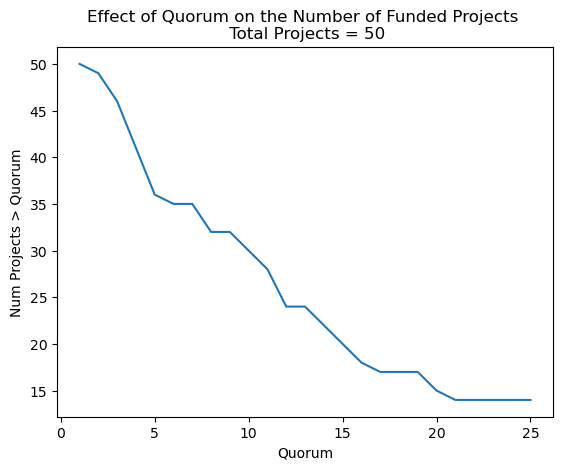

In [8]:
####Getting metrics
def count_projects_meeting_quorum(project_vote_counts, quorum):
    return sum(1 for votes in project_vote_counts.values() if votes >= quorum)

#Get votes 
all_votes = simulation_obj.badgeholder_population.get_all_votes()
project_vote_counts = defaultdict(int) # initialize dictionary to count votes
for vote in all_votes: #aggregating votes
    project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0


#Placeholders
quorum_vec = list(np.arange(1, 26))
project_pass_vec = []

#Counting projects meeting the variable quorum
for q in quorum_vec:
    num_projects_meeting_quorum = count_projects_meeting_quorum(project_vote_counts, q)
    project_pass_vec.append(num_projects_meeting_quorum)

# Plot the results
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 50')
plt.show()

In [9]:
####Same thing but with multiple simulation and more similar to original code 

#Placeholders
quorum_vec = list(np.arange(1, 26))
project_pass_vec = []

for q in quorum_vec: #Alternitavely we could just have the simulation outside the loop for efficiecy
    #Configuring & runnning Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Counting votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Count projects meeting the quorum
    num_projects_meeting_quorum = count_projects_meeting_quorum(project_vote_counts, q)
    project_pass_vec.append(num_projects_meeting_quorum)

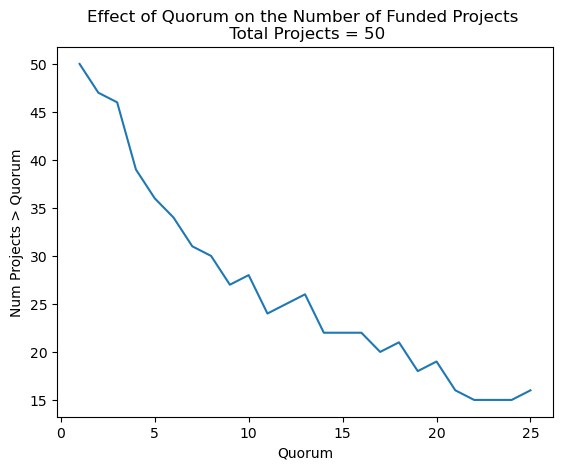

In [10]:
# Plot the results
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 50')
plt.show()

In [11]:
#####Graph 2

score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this 
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

for score_fn, q in sim_configs:
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

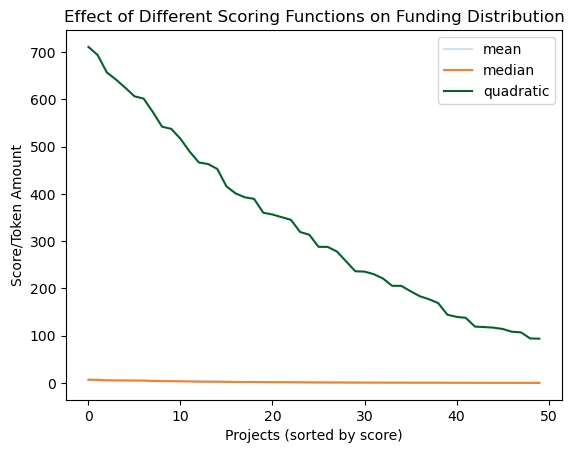

In [12]:
# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()

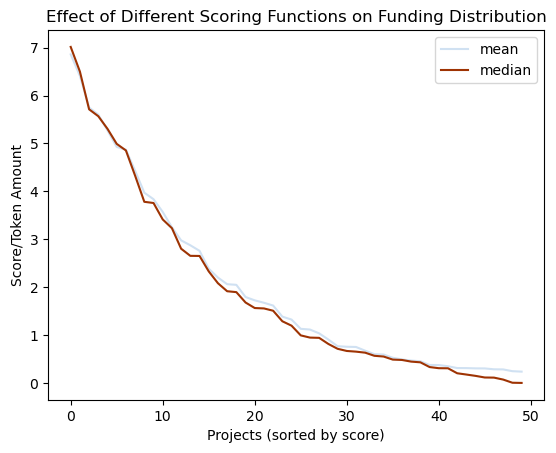

In [13]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median']#, 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in sim_configs:
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
    
    # Store results
    pass_results.append({
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.00it/s]


Project 0 (mean): 6.92733647180612
Project 1 (mean): 1.109689181350533
Project 2 (mean): 1.0251413609387972
Project 3 (mean): 0.9020097302631287
Project 4 (mean): 0.7586632903703656
Project 5 (mean): 0.7623116115274915
Project 6 (mean): 0.7516902624231767
Project 7 (mean): 0.6741231111741032
Project 8 (mean): 0.606873576979771
Project 9 (mean): 0.5856530818018575
Project 10 (mean): 0.5216421536950098
Project 11 (mean): 0.46699926471442926
Project 12 (mean): 0.3049806941197623
Project 13 (mean): 0.4482482960792821
Project 14 (mean): 0.3759526321708679
Project 15 (mean): 0.34935922130434405
Project 16 (mean): 0.30934715070253105
Project 17 (mean): 0.30659724355563467
Project 18 (mean): 0.27748262356796816
Project 19 (mean): 0.2378617407390892
Project 20 (mean): 0.2810984302036106
Project 21 (mean): 0.24815813427315886
Project 22 (mean): 0.2972625883220041
Project 23 (mean): 1.1181663724797255
Project 24 (mean): 1.3247884527917324
Project 25 (mean): 1.3724153869285716
Project 26 (mean): 1

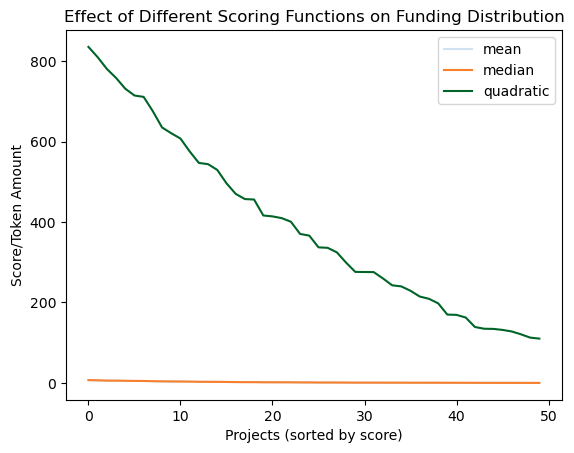

In [14]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
        print(f"Project {project.project_id} ({score_fn}): {score}")  # Debugging line
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.62it/s]

Project 0 votes: [2.2827492147498427, 7.2039573450414425, 1.9999081752132593, 12.219155587678424, 5.764851281238999, 12.877498788613973, 8.737488407377613, 1.999786849582409, 10.256630063197594, 0.04238170097633076, 8.64313934235164, 3.433243052814634, 11.258820512267723, 12.730628309509834, 2.3900191653603047, 12.713425576458762, 10.795573112358227, 12.103178889782994, 8.61241088590745, 11.483420239409712, 13.36209572887028, 1.4537459883287924, 10.194179475190102, 6.332319889213126, 11.805049525479989, 9.278555581031746, 13.707452521724328, 8.160853019921218, 2.566459272901693, 11.073743147277456, 8.597456883174933, 12.64700264630466, 10.65795353037785, 12.357827278390708, 7.091924027533049, 2.3639446022024675, 10.325502835655204, 1.0144026970054214, 13.979949260414216, 2.0374322120000805, 7.237730413731787, 5.181527333396091, 13.421921098624152, 6.8856957566288886, 10.306752536106437, 4.280448269176154, 7.330377199435913, 2.923811377615995, 5.41097930789291, 13.156469920259275, 9.971

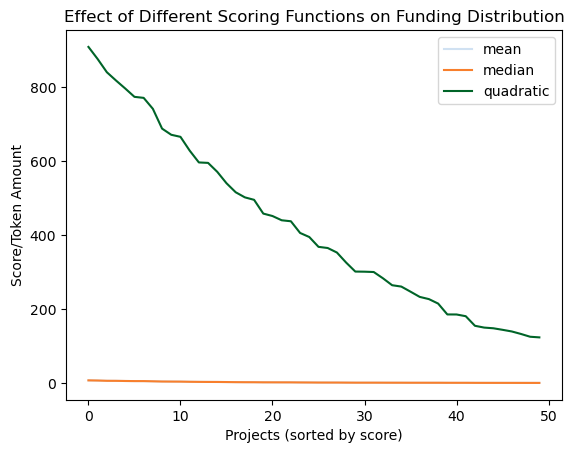

In [15]:
# Define scoring functions and quorum values
score_fns = ['mean', 'median', 'quadratic']
quorum = 1  # Set a fixed quorum for this analysis
sim_configs = list(itertools.product(score_fns, [quorum]))
pass_results = []

# Run simulations for different scoring functions
for score_fn, q in tqdm(sim_configs):
    # Configuring & running Sim
    badgeholders.reset_all()
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
    )
    projects = project_population.get_projects()
    simulation_obj.run(cast_votes_kwargs={'projects': projects})
    
    # Collect all votes
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    
    # Count votes for each project
    project_vote_counts = defaultdict(int)
    for vote in all_votes:
        project_vote_counts[vote.project.project_id] += vote.amount if vote.amount is not None else 0
    
    # Calculate token amounts based on different scoring methods
    project_scores = []
    for project in projects:
        votes = [vote.amount for vote in project.votes if vote.amount is not None]
        print(f"Project {project.project_id} votes: {votes}")  # Debugging line for votes
        if score_fn == 'mean':
            score = np.mean(votes) if votes else 0
        elif score_fn == 'median':
            score = np.median(votes) if votes else 0
        elif score_fn == 'quadratic':
            score = np.sum(np.sqrt(votes)) if votes else 0
        project.token_amount = score
        project_scores.append(score)
        print(f"Project {project.project_id} ({score_fn}): {score}")  # Debugging line for scores
    
    # Store results
    pass_results.append({
        'quorum': q,
        'score_fn': score_fn,
        'project_scores': project_scores,
    })

# Plotting
plt.figure()
cmap_means = plt.get_cmap('Blues')
cmap_medians = plt.get_cmap('Oranges')
cmap_quadratics = plt.get_cmap('Greens')
cmap_access_vec = np.linspace(0.2, 0.9, len(pass_results))

for p in pass_results:
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_access_vec[0])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='mean' if cmap_access_vec[0] == cmap_access_vec[0] else "")
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_access_vec[1])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='median' if cmap_access_vec[1] == cmap_access_vec[1] else "")
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_access_vec[2])
        plt.plot(sorted(p['project_scores'], reverse=True), color=cc, label='quadratic' if cmap_access_vec[2] == cmap_access_vec[2] else "")

plt.xlabel('Projects (sorted by score)')
plt.ylabel('Score/Token Amount')
plt.title('Effect of Different Scoring Functions on Funding Distribution')
plt.legend()
plt.show()
